In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


<ipython-input-1-c7ebdf48cf48>:21: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [2]:
clr_N2_20kb = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK15_JK89_JK90_XV_30_20000_raw.cool')
clr_xv_20kb = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK85_JK103_30_20000_raw.cool')

clr_N2_inset = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK15_JK89_JK90_XV_30_10000_raw.cool')
clr_xv_inset = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK85_JK103_30_10000_raw.cool')

clr_N2_2kb = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK15_JK89_JK90_XV_30_2000_raw.cool')
clr_xv_2kb = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK85_JK103_30_2000_raw.cool')


clr_N2_1 = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK15_XV_30_2000_raw.cool')
clr_N2_2 = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK89_JK90_XV_30_2000_raw.cool')

clr_xv_1 = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK85_30_2000_raw.cool')
clr_xv_2 = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK103_30_2000_raw.cool')



In [3]:
bw_N2 = pyBigWig.open("/scratch/kimj50/chip-chip/rescale/wt_chipchip_ypT47_rescaled_distal5mbfromfusion.bw")
bw_xv = pyBigWig.open("/scratch/kimj50/chip-chip/rescale/xv_chipchip_ypT47_rescaled_distal5mbfromfusion.bw")

bw_activeTrack = pyBigWig.open("/scratch/cgsb/ercan/Jun_ChIP/AKM61_AKM64_ypT47_MAPQ1_ratio.bw")

In [24]:
def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)

def a_subt_b_list(list_a,list_b):
    diff = []
    zip_obj = zip(list_a, list_b)
    for list_a_i, list_b_i in zip_obj:
        diff.append(list_a_i-list_b_i)
    return(diff)

nthreads = 1
def my_expected(clr,regions):
    with multiprocess.Pool(nthreads) as pool:
        expected = cooltools.expected.diagsum(
            clr,
            regions=regions,
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
            },
            map=pool.map
        )
    expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']
    return(expected)

def eigdecomp_saddle(clr,region,nbins,activebw):
    chrom = "".join(['chr', region['chrom'][0]])
    clr_region = clr.bins().fetch(region['chrom'].item())
    lst_region = [clr_region['start'],clr_region['end']]
    binnify_bw = []
    
    for i in range(0,len(lst_region[0])):
        v = activebw.stats(chrom,
                           lst_region[0].reset_index(drop=True)[i],
                           lst_region[1].reset_index(drop=True)[i],
                           type='mean',nBins=1)[0]
        #binnify_bw.append(float(v))
        binnify_bw.append(v)
    clr_region['bw'] = binnify_bw
    
    lam,eig = cooltools.eigdecomp.cooler_cis_eig(clr=clr,
                                          bins=clr_region,
                                          regions=region,
                                          n_eigs=1,
                                          balance='weight', 
                                          ignore_diags=2,
                                          clip_percentile=99.9,
                                          sort_metric=None,phasing_track_col='bw')
    histbins=nbins
    binedges = np.linspace(0, 1, histbins)
    binedges_q = cooltools.saddle.quantile(eig['E1'], binedges)
    digitized, hist = cooltools.saddle.digitize_track(binedges_q,track=(eig, 'E1'))
    exp = cooltools.expected.diagsum(
        clr=clr,
        regions=region,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    exp['balanced.avg'] = (exp['balanced.sum'] / exp['n_valid'])
    getexp = cooltools.saddle.make_cis_obsexp_fetcher(clr, (exp,'balanced.avg'), weight_name='weight')
    int_sum,int_count = cooltools.saddle.make_saddle(getmatrix=getexp, 
                             binedges=binedges_q, 
                             digitized=(digitized,'E1.d'), 
                             contact_type='cis', regions=region, 
                             min_diag=3, max_diag=-1,
                             trim_outliers=False, verbose=False)
    COMP = cooltools.saddle.saddle_strength(int_sum, int_count)
    COMP_rescaled = (COMP-1)/(COMP+2)
    COMP_summary = {'COMP': COMP, 
                    'COMP_rescaled': COMP_rescaled,
                    'chr': ((" " + region['chrom'][0])*len(COMP)).split(),
                    'sample': str(clr)
                   }
    COMP_summary_df = pd.DataFrame(COMP_summary)
    return(digitized,hist,binedges,int_sum,int_count,COMP_summary_df)

def save_E1_asBedgraph(eigdecomp_saddle_perchr_digitized,save_as):
    a = eigdecomp_saddle_perchr_digitized
    out_lst = []
    for i in range(len(a)):
        b = a[i][0][['chrom','start','end','E1']]
        out_lst.append(b)
    c = pd.concat(out_lst,axis=0).dropna()
    c['chrom'] = 'chr' + c['chrom'].astype(str)
    c.to_csv(save_as,sep="\t",quoting=csv.QUOTE_NONE,index=False,header=False)
    
def a_subt_b_list(list_a,list_b):
    diff = []
    zip_obj = zip(list_a, list_b)
    for list_a_i, list_b_i in zip_obj:
        diff.append(list_a_i-list_b_i)
    return(diff)
def compute_COMP(saddleMatrix):
    M = saddleMatrix # numpy 2d array
    s = len(M)
    BB1,BB2 = np.arange(0,s//2),np.arange(0,s//2)
    AA1,AA2 = np.arange(s-s//2,s),np.arange(s-s//2,s)
    BA1,BA2 = np.arange(0,s//2),np.arange(s-s//2,s)
    AB1,AB2 = np.arange(s-s//2,s),np.arange(0,s//2)
    BB = M[np.ix_(BB1, BB2)]
    AA = M[np.ix_(AA1, AA2)]
    BA = M[np.ix_(BA1, BA2)]
    AB = M[np.ix_(AB1, AB2)]
    COMP = (np.average(AA)+np.average(BB))/(np.average(AB)+np.average(BA))
    return(COMP)

def rescale_COMP(COMP_lst):
    x = np.array(COMP_lst)
    y = (x-1)/(x+1)
    return(y)

def make_sliders(bed,stepSize,nSteps,LorR):
    a = list()
    b = list()
    c = list()
    chrom = bed['chrom'][0]
    for i in range(nSteps):
        if LorR == 'L':
            a_i = bed['start']-(i)*stepSize
            b_i = bed['end']-(i)*stepSize
        if LorR == 'R':
            a_i = bed['start']+(i)*stepSize
            b_i = bed['end']+(i)*stepSize
        a.append(int(a_i))
        b.append(int(b_i))
        c.append(chrom)
    x = pd.DataFrame({'chrom': c,'start': a,'end': b})
    return(x)

import time

def slider_Saddle_COMP(clr,slider_lst,q,activeTrk):
    ti = time.time()
    output = []
    for s in range(len(slider_lst)):
        print('slider_lst_element ' + str(s))
        saddle_s = []
        COMP_s = []
        for i in range(len(slider_lst[s])):
            print(slider_lst[s].loc[[i]])
            x = eigdecomp_saddle(clr,slider_lst[s].loc[[i]].reset_index(drop=True),q,activeTrk)
            a = x[3]/x[4]
            b = np.delete(a, (0,len(a)-1), axis=0)
            c = np.delete(b, (0,len(a)-1), axis=1)
            d = compute_COMP(c)
            saddle_s.append(c)
            COMP_s.append(d)
        output.append([saddle_s,COMP_s])
    tf = time.time()
    print(tf-ti)
    return(output)

def combined_COMP_df(slider_lst,COMP_lst1,COMP_lst2):
    COMP_lst12 = []
    for i in range(len(slider_lst)):
        print(i)
        slider_i = slider_lst[i]
        slider_i['COMP_1'] = COMP_lst1[i][1]
        slider_i['COMP_1_rescale'] = rescale_COMP(COMP_lst1[i][1])
        slider_i['COMP_2'] = COMP_lst2[i][1]
        slider_i['COMP_2_rescale'] = rescale_COMP(COMP_lst2[i][1])
        slider_i['valid'] = np.logical_and(slider_i['COMP_1']>1,slider_i['COMP_2']>1)
        if i == 4:
            XV_site = 17718513
            slider_i_x = slider_i[slider_i['end']<XV_site]
            slider_i_v = slider_i[slider_i['start']>XV_site]
            slider_i = pd.concat([slider_i_x.replace('XV', 'XV_x'),slider_i_v.replace('XV', 'XV_v')])
        COMP_lst12.append(slider_i)
    return pd.concat(COMP_lst12)

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    x = np.array(lb_slopes_agg['s_bp'])
    y = np.array(lb_slopes_agg['slope'])
    loop_size = x[argrelextrema(y, np.greater)]
    return(lb_cvd_agg,lb_slopes_agg,loop_size)



def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    b = mid[(mid > start) & (mid < end)]
    return(np.array(b))

In [5]:
xv_chromSizes= bioframe.read_table('/scratch/cgsb/ercan/juicer/references/ypT47.chrom.sizes',schema='bed3')['start']

In [7]:
# max slider for each chr
maxn = (xv_chromSizes-2000000)//200000
all_2mb=bioframe.read_table('XV/slide3/A_control/all_2mb.bed',schema='bed3')
all_slider_lst = []
for i in range(5):
    x = make_sliders(all_2mb.iloc[[i]].reset_index(drop=True),200000,maxn[i],'R')
    x = bioframe.parse_regions(x)
    all_slider_lst.append(x)

all_slider_lst[0].tail()

,chrom,start,end,name
60,I,12000000,14000000,I:12000000-14000000
61,I,12200000,14200000,I:12200000-14200000
62,I,12400000,14400000,I:12400000-14400000
63,I,12600000,14600000,I:12600000-14600000
64,I,12800000,14800000,I:12800000-14800000


In [8]:
#all_slider_lst
#sliders = [Xside_slider,Vside_slider]
sliders = all_slider_lst
#COMP_sliders_N2 = slider_Saddle_COMP(clr_N2_2kb,sliders,25,bw_activeTrack)
#COMP_sliders_xv = slider_Saddle_COMP(clr_xv_2kb,sliders,25,bw_activeTrack)


In [9]:
### compute COMP and combine data
sliders = all_slider_lst

#COMP_slider_N2_xv = combined_COMP_df(sliders,COMP_sliders_N2,COMP_sliders_xv)

In [10]:
# save
#COMP_slider_N2_xv.to_pickle('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/XV_E1/COMP_slider_2kbHiC')

In [11]:
# load
COMP_slider_N2_xv = pd.read_pickle('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/XV_E1/COMP_slider_2kbHiC')

/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
<ipython-input-5-cba8926f77fc>:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


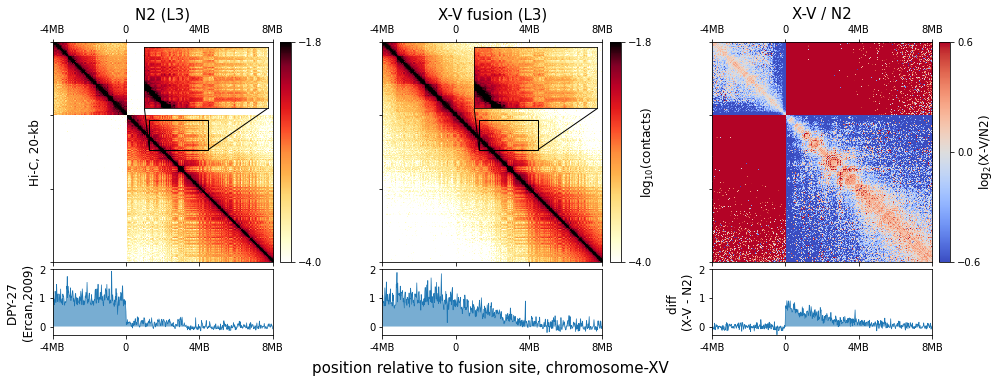

In [5]:
##### snap shot ####

f, axs = plt.subplots(
    figsize=(14, 8),
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=False
)

#### data
clrs = [clr_N2_20kb,clr_xv_20kb]
clrs_inset = [clr_N2_inset,clr_xv_inset]
bws = [bw_N2,bw_xv]
#bws_E1 = [E1_N2,E1_xv]
####

# params
sub_titles = ['N2 (L3)','X-V fusion (L3)',"X-V / N2"]
row_labels = ['Hi-C, 20-kb','DPY-27 \n(Ercan,2009)']
smallFont = 12
bigFont = 15
minmax_clr = [-4,-1.8]
minmax_clr_inset = [-3.9,-1.8]
minmax_oe = [-0.6,0.6]
minmax_bw = [-0.3,2]


# region 
XV_site = 17718513
up = 4_000_000
down = 8_000_000
start,end = XV_site-up, XV_site+down
region = 'XV:'+str(start)+'-'+str(end)
extents = (start, end, end, start)

ticks_pixels = [17718513-4000000,17718513,17718513+4000000,17718513+8000000]
#ticks_labels = [0,2,4,6]
ticks_labels = ["-4MB",'0','4MB','8MB']

# inset region
x1, x2, y1, y2 = 19_000_000, 22_200_000, 19_600_000,18_000_000
region_inset = [x1,x2,y1,y2]
def inset_wrapper(main_axis,inset_axis,inset_x1x2y1y2):
    inset_axis.set_xlim(inset_x1x2y1y2[0],inset_x1x2y1y2[1])
    inset_axis.set_ylim(inset_x1x2y1y2[2],inset_x1x2y1y2[3])
    inset_axis.yaxis.set_visible(False)
    inset_axis.xaxis.set_visible(False)
    patch, pp1,pp2 = mark_inset(main_axis, inset_axis, loc1=1,loc2=1)
    pp1.loc1 = 3
    pp1.loc2 = 2
    pp2.loc1 = 4
    pp2.loc2 = 1

####### obs

for i in range(2):
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_clr[0],vmax=minmax_clr[1],
        extent=extents)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_clr[0],minmax_clr[1]])
    ax.set_title(sub_titles[i],fontsize=bigFont)
    if i == 0:
        ax.set(ylabel=row_labels[0])
        ax.yaxis.label.set_size(smallFont)
    else:
        cbar.ax.set_ylabel('$\log_{10}$(contacts)', rotation=90,fontsize=smallFont,labelpad=-13)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=True)
    ax.set(xticks=ticks_pixels,xticklabels=ticks_labels,yticks=ticks_pixels,yticklabels=[])
    
    ### inset ###
    axins = zoomed_inset_axes(ax, 2.1, loc=1)
    clr_region_inset = cgi_region(clrs_inset[i],region)
    axins.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_clr_inset[0],vmax=minmax_clr_inset[1],
        extent=extents)
    inset_wrapper(ax,axins,region_inset)

    ##### chip chip ####
    ax1 = divider.append_axes("bottom", size="30%", pad=0.1)
    bw_region = bws[i].stats('chrXV',start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(
        xval[mask],
        yval[mask],lw=0.7)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
    ax1.set_ylim([minmax_bw[0],minmax_bw[1]])
    ax1.set_xlim(xval.min(),xval.max())
    if i == 0:
        ax1.set(ylabel=row_labels[1])
        ax1.yaxis.label.set_size(smallFont)
    ax1.set(xticks=ticks_pixels,xticklabels=ticks_labels)

############### log2ratio
ax = axs[2]
clr_region1 = cgi_region(clrs[0],region)
clr_region2 = cgi_region(clrs[1],region)
im = ax.matshow(
    np.log2(clr_region2/clr_region1),
    cmap='coolwarm',
    extent=extents,
    vmin=minmax_oe[0],vmax=minmax_oe[1]
    )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, ticks=[minmax_oe[0],0,minmax_oe[1]])
cbar.ax.set_ylabel('$\log_{2}$(X-V/N2)', rotation=90,fontsize=smallFont,labelpad=-5)
ax.set_title(sub_titles[2],fontsize=bigFont)
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=True)
ax.set(xticks=ticks_pixels,xticklabels=ticks_labels,yticks=ticks_pixels,yticklabels=[])



##### chip chip ####
ax1 = divider.append_axes("bottom", size="30%", pad=0.1)
bw1 = bws[0].stats('chrXV',start,end,type="mean",nBins=len(clr_region1))
bw2 = bws[1].stats('chrXV',start,end,type="mean",nBins=len(clr_region1))
bw_diff = a_subt_b_list(bw2,bw1)

xval=np.linspace(start, end, len(clr_region1))
yval=np.array(bw_diff,dtype=float)
mask = np.isfinite(yval)
ax1.plot(
    xval[mask],
    yval[mask],lw=0.7)
plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
ax1.set_ylim([minmax_bw[0],minmax_bw[1]])
ax1.set_xlim([xval.min(),xval.max()])
ax1.set(xticks=ticks_pixels,xticklabels=ticks_labels)
ax1.set(ylabel='diff \n(X-V - N2)')
ax1.yaxis.label.set_size(smallFont)

f.text(0.49, 0.18, 'position relative to fusion site, chromosome-XV', ha='center',fontsize=bigFont)

plt.tight_layout()

In [6]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2_snapshot_HiC20kb_inset10kb.pdf',dpi=1200,bbox_inches='tight')

/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
<ipython-input-14-0edd7112acee>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


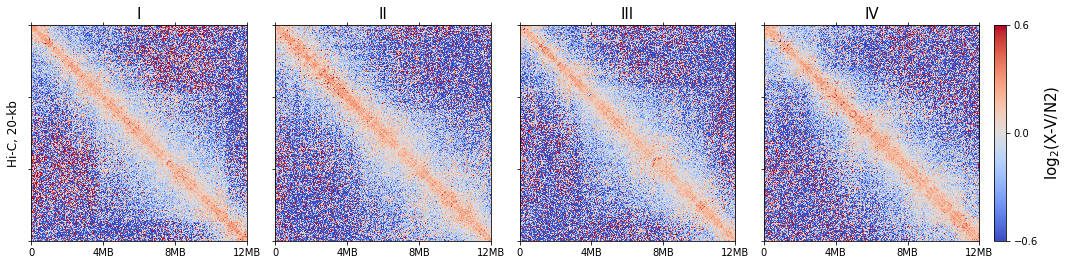

In [14]:
############# plot control regions ##################

f, axs = plt.subplots(
    figsize=(14, 6),
    nrows=1,
    ncols=4,
    sharex=False,
    sharey=False
)

#### data
clrs = [clr_N2_20kb,clr_xv_20kb]

# params
#sub_titles = ['','X-V fusion',"X-V / N2"]
row_labels = ['Hi-C, 20-kb']
smallFont = 12
bigFont = 15
minmax_oe = [-0.6,0.6]

ticks_pixels = [0,4_000_000,8_000_000,12_000_000]
#ticks_labels = [0,2,4,6]
ticks_labels = ['0','4MB','8MB','12MB']



# region
chroms = ['I','II','III','IV']
start,end = 0, 12_000_000




for i in range(len(chroms)):
    ax = axs[i]
    region = chroms[i]+':'+str(start)+'-'+str(end)
    extents = (start, end, end, start)
    clr_region1 = cgi_region(clrs[0],region)
    clr_region2 = cgi_region(clrs[1],region)
    im = ax.matshow(
        np.log2(clr_region2/clr_region1),
        cmap='coolwarm',
        extent=extents,
        vmin=minmax_oe[0],vmax=minmax_oe[1]
    )
    divider = make_axes_locatable(ax)
#    cax = divider.append_axes("right", size="5%", pad=0.1)
#    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_oe[0],0,minmax_oe[1]])
#    cbar.ax.set_ylabel('$\log_{2}$(X-V/N2)', rotation=90,fontsize=smallFont,labelpad=-5)
    ax.set_title(chroms[i],fontsize=bigFont)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)
    ax.set(xticks=ticks_pixels,xticklabels=ticks_labels,yticks=ticks_pixels,yticklabels=[])

axs[0].set_ylabel('Hi-C, 20-kb',fontsize=smallFont)

cbaxes = f.add_axes([0.99, .25, 0.012, 0.5]) 
cbar = plt.colorbar(im, cax = cbaxes, ticks=[minmax_oe[0],0,minmax_oe[1]])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel('$\log_{2}$(X-V/N2)', rotation=90,fontsize=bigFont)



plt.tight_layout()

In [15]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2s_globaleffect_HiC20kb.pdf',dpi=800,bbox_inches='tight')

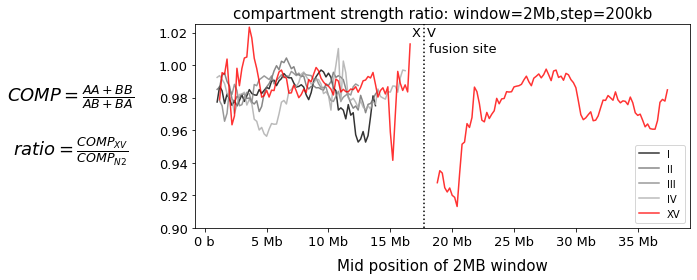

In [18]:
f, axs = plt.subplots(
    figsize=(10, 4),
    nrows=1,
    ncols=1,
    sharex=False,
    sharey=False
)


dat = COMP_slider_N2_xv.replace('XV_x','XV')
## compute ratio and mid
dat['mid'] = (dat['end']+dat['start'])/2
dat['ratio'] = dat['COMP_2']/dat['COMP_1']

# global param
XV_site = 17718513
yminmax = [0.9,1.025]
colors = ['black','dimgrey','grey','darkgrey','red','red']
smallFont = 13
bigFont = 15


sns.lineplot(ax=axs,data=dat[dat['valid']==True], x='mid', y='ratio', hue='chrom',palette=colors,alpha=0.8)
format_ticks(axs,x=True,y=False,rotate=False)

hand, labl = axs.get_legend_handles_labels()
#axs.legend(labl[:5],bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1,prop={'size': 13})

axs.legend(labl[:5], loc='lower right', ncol=1,prop={'size': 10})

axs.vlines(XV_site,yminmax[0],yminmax[1], linestyles ="dotted",color='black')
plt.ylim(yminmax[0],yminmax[1])
axs.text(XV_site+400_000,1.008,'fusion site',fontsize=smallFont,color='black')
axs.text(XV_site-600_000,1.018,'X',fontsize=smallFont,color='black',ha='center')
axs.text(XV_site+600_000,1.018,'V',fontsize=smallFont,color='black',ha='center')
axs.set_title('compartment strength ratio: window=2Mb,step=200kb',fontsize=bigFont)
axs.set_xlabel('Mid position of 2MB window',fontsize=bigFont,labelpad=10)
axs.set_ylabel(r"$COMP = \frac{AA + BB}{AB + BA}$" 
               "\n"
               "\n"
               r"$ratio = \frac{COMP_{XV}}{COMP_{N2}}$",rotation=0,fontsize=18, labelpad=90)
axs.yaxis.set_label_coords(-0.25,0.3)
axs.tick_params(axis='both', which='major', labelsize=smallFont)


plt.tight_layout()

In [19]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2_XV_COMP_ratio_HiC2kb.pdf',dpi=1200,bbox_inches='tight')

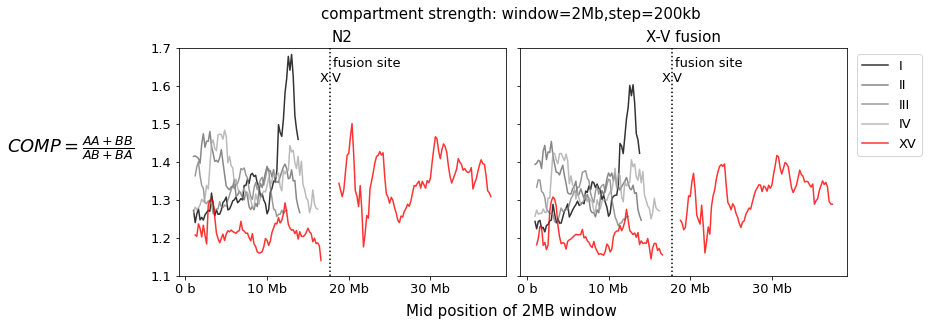

In [21]:
f, axs = plt.subplots(
    figsize=(13, 4),
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True
)

dat = COMP_slider_N2_xv.replace('XV_x','XV')
## compute ratio and mid
dat['mid'] = (dat['end']+dat['start'])/2
dat['ratio'] = dat['COMP_2']/dat['COMP_1']

# global param
subtitles = ['N2','X-V fusion']
XV_site = 17718513
yminmax = [1.1,1.7]
colors = ['black','dimgrey','grey','darkgrey','red','red']
smallFont = 13
bigFont = 15



colors = ['black','dimgrey','grey','darkgrey','red','red']
sns.lineplot(ax=axs[0],data=dat[dat['valid']==True], x='mid', y='COMP_1', hue='chrom',palette=colors,alpha=0.8)
sns.lineplot(ax=axs[1],data=dat[dat['valid']==True], x='mid', y='COMP_2', hue='chrom',palette=colors,alpha=0.8)
format_ticks(axs[1],x=True,y=False,rotate=False)
plt.ylim(yminmax[0],yminmax[1])


for i in range(2):
    axs[i].set_title(subtitles[i],fontsize=bigFont)
    axs[i].vlines(XV_site,yminmax[0],yminmax[1], linestyles ="dotted",color='black')
    axs[i].text(XV_site+400_000,1.65,'fusion site',fontsize=smallFont,color='black')
    axs[i].text(XV_site-700_000,1.61,'X',fontsize=smallFont,color='black',ha='center')
    axs[i].text(XV_site+700_000,1.61,'V',fontsize=smallFont,color='black',ha='center')
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='both', labelsize=smallFont)

#axs.set_title('compartment strength ratio: window=2Mb,step=200kb',fontsize=bigFont)
axs[0].set_ylabel(r"$COMP = \frac{AA + BB}{AB + BA}$",rotation=0,fontsize=18, labelpad=80)



axs[0].get_legend().remove()
hand, labl = axs[1].get_legend_handles_labels()
axs[1].legend(labl[:5],bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1,prop={'size': 13})

    
f.text(0.55, 1, 'compartment strength: window=2Mb,step=200kb', ha='center',fontsize=bigFont)        
f.text(0.55, -0.03, 'Mid position of 2MB window', ha='center',fontsize=bigFont)    


plt.tight_layout()

In [22]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2s_XV_COMP_HiC2kb.pdf',dpi=1200,bbox_inches='tight')

In [8]:
##### chr i - iv, 
xv_A = bioframe.read_table('XV/xv_A.bed',schema='bed3')
xv_A = bioframe.parse_regions(xv_A)


###### chr X rest
xv_X=bioframe.read_table('XV/skip100kb/Xrest.bed',schema='bed3')
xv_X=bioframe.parse_regions(xv_X)

###### chr V rest
xv_V=bioframe.read_table('XV/skip100kb/Vrest.bed',schema='bed3')
xv_V=bioframe.parse_regions(xv_V)


###### chr xv V arm
xv_V1=bioframe.read_table('XV/skip100kb/Vside1.bed',schema='bed3')
xv_V1=bioframe.parse_regions(xv_V1)

###### chr X
xv_X1=bioframe.read_table('XV/skip100kb/Xside1.bed',schema='bed3')
xv_X1=bioframe.parse_regions(xv_X1)



xv_regions = [xv_A,xv_X,xv_X1,xv_V1,xv_V]

xv_regions_labels = ['chrI-IV','distal X','proximal X','proximal V','distal V']

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [24]:
N2_agg = []
xv_agg = []

for i in range(len(xv_regions)):
    print(i)
    x = scaling_agg(clr_N2_2kb,xv_regions[i])
    N2_agg.append(x)
    print(i)
    x = scaling_agg(clr_xv_2kb,xv_regions[i])
    xv_agg.append(x)
    

0
0
1
1
2
2
3
3
4
4


[400763.51789439]
[158421.40209901]
[125650.29783528]
[400641.22278003]
[504594.14096663]
[  6928.20323028 400763.59749424]
[125663.42677276]
[125650.97103654]
[200085.26920106]
[400758.66625693]


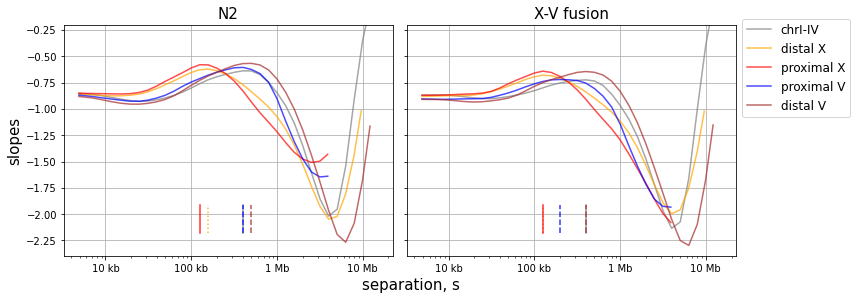

In [26]:
f, axs = plt.subplots(
    figsize=(12, 4),
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True
)

xv_regions_labels = ['chrI-IV','distal X','proximal X','proximal V','distal V']
colors = ['grey','orange','red','blue','brown']
sub_titles = ['N2','X-V fusion']
dat = [N2_agg,xv_agg]

bigFont = 15
smallFont = 10

#dat = [N2_1_agg,N2_2_agg,xv_1_agg,xv_2_agg]
lineStyle=['-',':','-','--','--']

for j in range(len(dat)):
    dat_j = dat[j]
    ax = axs[j]
    for i in range(len(dat_j)):
        ax.semilogx(dat_j[i][1]['s_bp'],dat_j[i][1]['slope'],color=colors[i],alpha=0.7,label=xv_regions_labels[i])
        x = dat_j[i][2]
        print(x)
        loops1 = x[np.logical_and(x>50000,x<=1000000)]
        for k in range(len(loops1)):
            ax.axvline(loops1[k],ymin=0.1,ymax=0.22,alpha=0.8,color=colors[i],linestyle=lineStyle[i])
    ax.set_ylim(-2.4,-0.2)
    ax.set(ylabel='')
    ax.set_title(sub_titles[j],fontsize=bigFont)
    ax.grid()
    format_ticks(ax,y=False,rotate=False)
    if j == 0:
        ax.set(ylabel='slopes')
        ax.yaxis.label.set_size(bigFont)
    
f.text(0.48, -0.02, 'separation, s', ha='center',fontsize=bigFont)
axs[1].legend(loc=(1.02,0.6),prop={'size': 12})


plt.tight_layout()

In [28]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2_slopes.pdf',dpi=1200,bbox_inches='tight')

In [30]:
# agg_lst: list of aggs
# agg_lst_labels: label to put on each element of agg
# agg_labels: within each element of agg_lst, list of labels to label genomic regions
def pd_loopsize(agg_lst,agg_lst_labels,agg_labels):
    agg_all_loops = []
    for i in range(len(agg_lst)):
        agg_i = agg_lst[i]
        agg_i_loops = []
        for j in range(len(agg_i)):
            x = agg_i[j][2]
            x1 = x[np.logical_and(x>50000,x<=1000000)]
            if len(x1)==1:
                agg_i_loops.append(int(x1))
            else:
                print('loop count not 1')
        agg_all_loops.append(agg_i_loops)    
    agg_all_loops_flat = list(itertools.chain(*agg_all_loops))
    conditions_flat = list(itertools.chain.from_iterable(itertools.repeat(x, len(agg_labels)) for x in agg_lst_labels))
    d= {'loopsize': agg_all_loops_flat, 'chrom': agg_labels*len(agg_lst_labels), 'condition':conditions_flat}
    return pd.DataFrame(data=d)

dat = [N2_agg,xv_agg]
xv_regions_labels = ['chrI-IV','distal X','proximal X','proximal V','distal V']
t = pd_loopsize(dat,['N2','XV'],xv_regions_labels)

#dat = [N2_1_agg,N2_2_agg,xv_1_agg,xv_2_agg]
#tr = pd_loopsize(dat,['N2_1','N2_2','XV_1','XV_2'],xv_regions_labels)


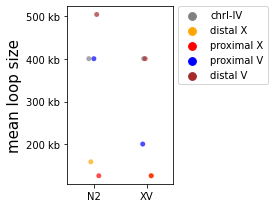

In [57]:
### comp score, center
f, axs = plt.subplots(
    figsize=(4, 3),
    nrows=1,
    ncols=1,
    sharey='row'
)

colors = ['grey','orange','red','blue','brown']

a = sns.stripplot(data=t,x='condition', y='loopsize',hue='chrom',palette=colors,alpha=0.7,jitter=True,size=5)
a.get_legend().remove()
a.set_title('')



format_ticks(a,x=False,y=True,rotate=False)

a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
a.set_ylabel('mean loop size' ,rotation=90,fontsize=15,labelpad=4)
a.set_xlabel('')

plt.tight_layout()

In [58]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2_loopsize.pdf',dpi=1200,bbox_inches='tight')

0    11518513
dtype: int64
0    5000000
dtype: int64
0    5000000
dtype: int64
0    14723648
dtype: int64


Text(31500000, -1.4, 'Chromosome-V')

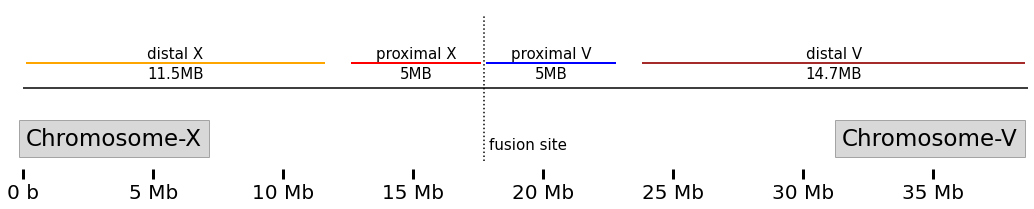

In [60]:
########################## cartoon of XV annotation ############################
f, axs = plt.subplots(
    figsize=(18,3),
    ncols=1,
    nrows=1,
    sharex=False,sharey=True
)

size_XV = 38642161
XV_site = 17718513
regions_lst = [xv_X,xv_X1,xv_V1,xv_V]
xv_regions_labels = ['distal X','proximal X','proximal V','distal V']
xv_regions_length_labels = ['11.5MB','5MB','5MB','14.7MB']

# global param
boxheight = 1.5
colors = ['orange','red','blue','brown']

axs.hlines(0,0,size_XV,color='black')
axs.set_ylim([-2,2])
axs.set_xlim([0,size_XV])

for i in range(len(regions_lst)):
    print(regions_lst[i]['end']-regions_lst[i]['start'])
    axs.hlines(0.6,regions_lst[i]['start'],regions_lst[i]['end'],color=colors[i],linewidth = 2)
    axs.text(x=(regions_lst[i]['start']+regions_lst[i]['end'])//2,y=0.72,s=xv_regions_labels[i],fontsize=15,
            horizontalalignment='center')
    axs.text(x=(regions_lst[i]['start']+regions_lst[i]['end'])//2,y=0.25,s=xv_regions_length_labels[i],fontsize=15,
            horizontalalignment='center')

axs.vlines(XV_site,-1.8,1.8, linestyles ="dotted",color='black')
axs.text(XV_site+200_000,-1.5,'fusion site',fontsize=15,color='black')


axs.spines['left'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.get_yaxis().set_ticks([])
format_ticks(axs,x=True,y=False,rotate=False)
axs.tick_params(axis='x', which='major', labelsize=20)
axs.xaxis.set_tick_params(width=3,length=10)

axs.text(100_000, -1.4, 'Chromosome-X', fontsize=23,
        bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 7})
axs.text(31_500_000, -1.4, 'Chromosome-V', fontsize=23,
        bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 7})



In [61]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2_slopes_regions.pdf',dpi=800,bbox_inches='tight')

In [6]:
def make_sliders(bed,stepSize,nSteps,LorR):
    a = list()
    b = list()
    c = list()
    chrom = bed['chrom'][0]
    for i in range(nSteps):
        if LorR == 'L':
            a_i = bed['start']-(i)*stepSize
            b_i = bed['end']-(i)*stepSize
        if LorR == 'R':
            a_i = bed['start']+(i)*stepSize
            b_i = bed['end']+(i)*stepSize
        a.append(int(a_i))
        b.append(int(b_i))
        c.append(chrom)
    x = pd.DataFrame({'chrom': c,'start': a,'end': b})
    return(x)


# max slider for each chri-iv
maxn = (xv_chromSizes-5_000_000)//200_000
all_5mb=bioframe.read_table('XV/slide3/A_control/all_5mb.bed',schema='bed3')
all_slider_lst = []
for i in range(5):
    x = make_sliders(all_5mb.iloc[[i]].reset_index(drop=True),200000,maxn[i],'R')
    x = bioframe.parse_regions(x)
    all_slider_lst.append(x)

all_slider_lst[4].tail()

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,chrom,start,end,name
163,XV,32600000,37600000,XV:32600000-37600000
164,XV,32800000,37800000,XV:32800000-37800000
165,XV,33000000,38000000,XV:33000000-38000000
166,XV,33200000,38200000,XV:33200000-38200000
167,XV,33400000,38400000,XV:33400000-38400000


In [ ]:
N2_aggs = []
xv_aggs = []
print(len(all_slider_lst[4]))
for i in range(len(all_slider_lst[4])):
    print(i)
    x = scaling_agg(clr_N2_2kb,all_slider_lst[4].loc[[i]].reset_index(drop=True))
    N2_aggs.append(x)
    x = scaling_agg(clr_xv_2kb,all_slider_lst[4].loc[[i]].reset_index(drop=True))
    xv_aggs.append(x)

In [7]:
def combine_Psslopes_lst(Agg_output_lst):
#    output = np.array(slopes_lst[0]['s_bp'])
    Ps_lst = []
    slopes_lst = []
    for i in range(len(Agg_output_lst)):
        Ps_lst.append(Agg_output_lst[i][0]['balanced.avg'])
        slopes_lst.append(Agg_output_lst[i][1]['slope'])
    return([np.column_stack(Ps_lst),np.column_stack(slopes_lst)])



#N2_Psslopes = combine_Psslopes_lst(N2_aggs)
#xv_Psslopes = combine_Psslopes_lst(xv_aggs)


In [65]:
#np.save('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/XV_E1/N2_slopes_window5mb_step200kb_XV', N2_Psslopes[1])
#np.save('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/XV_E1/xv_slopes_window5mb_step200kb_XV', xv_Psslopes[1])

In [8]:
N2_slopes = np.load('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/XV_E1/N2_slopes_window5mb_step200kb_XV.npy')
xv_slopes = np.load('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/XV_E1/xv_slopes_window5mb_step200kb_XV.npy')


In [9]:
dummy_agg = scaling_agg(clr_N2_2kb,all_slider_lst[4].loc[[0]].reset_index(drop=True))

In [10]:
#### replace regions containing fusion site with nan
all_slider_lst[4] ### bed file used to compute sliding window slopes

def fusionSite_nansubstitution(slopes_matrix,bedfile,fusionSite):
    x = np.invert(np.logical_or(bedfile['end'] < fusionSite,bedfile['start'] > fusionSite))
    m = slopes_matrix
    print(np.where(x)[0])
    m[:, np.where(x)[0]] = np.nan
    return(m)
    
    
    
N2_slopes_nan = fusionSite_nansubstitution(N2_slopes,all_slider_lst[4],17718513)



[64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88]


In [11]:
def find_localmax(slopes_matrix,dummy_slopes):
    b = dummy_slopes['s_bp']
    y = []
    z = []
    for i in range(slopes_matrix.shape[1]):
        x = slopes_matrix[:,i]
        if int(np.argmax(x)) == 0:
            y.append(np.nan)
            z.append(np.nan)
        else:
            y.append(int(np.argmax(x))) # index
            z.append(b[int(np.argmax(x))]) # bp loopsize
    return(y,z)


Text(0.5, 0, 'Chromosome-XV, mid position of 5MB window')

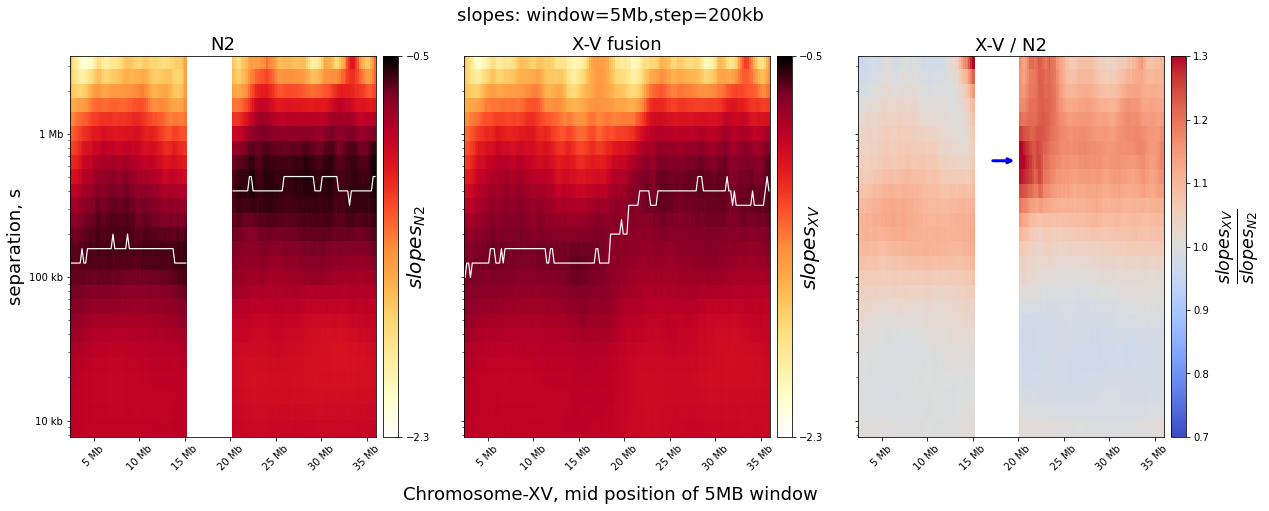

In [12]:
f, axs = plt.subplots(
    figsize=(20,7),
    ncols=3,
    nrows=1,
    sharex=True, sharey=True
)
# remove ends
a,b = 2,28
sliderUsed = all_slider_lst[4]
dummySlopes = dummy_agg[1][a:b].reset_index()
dat1 = N2_slopes_nan[a:b]
dat2 = xv_slopes[a:b]
dats = [dat1,dat2]
bigFont = 18
#(left, right, bottom, top)
#ext = (0,dat1.shape[1]*100,dat1.shape[0],0)
ext = (0,dat1.shape[1]*100,max(dummySlopes['s_bp']),min(dummySlopes['s_bp']))
################ global param
minmax_slopes = [-2.3,-0.5]
minmax_ratio = [0.7,1.3]
sub_titles = ['N2','X-V fusion',"X-V / N2"]
cbar_labels = [r"$slopes_{N2}$",r"$slopes_{XV}$"]

x = (sliderUsed['start']+sliderUsed['end'])/2
y =dummySlopes['s_bp']


for i in range(len(dats)):
    ax = axs[i]
    z = dats[i]
    im = ax.pcolor(x,y,z,
                    cmap='fall',
                    vmin=minmax_slopes[0],
                    vmax=minmax_slopes[1],
                   shading='auto')
    ax.set_yscale('log')
    format_ticks(ax,x=True,y=True)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax,ticks=[minmax_slopes[0],minmax_slopes[1]])

    cbar.ax.set_ylabel(cbar_labels[i], rotation=90,fontsize=20,labelpad=-25)
    
    xval = x
    loopsizes = find_localmax(dats[i],dummySlopes.reset_index())[1]
    yval = np.array(loopsizes,dtype=float)
    ax.plot(
        xval,
        yval,lw=1.2,color='white')

ax = axs[2]
z = dats[1]/dats[0]
im = ax.pcolor(x,y,z,
              cmap='coolwarm',
              vmin=minmax_ratio[0],
              vmax=minmax_ratio[1],
              shading='auto')
ax.set_yscale('log')
format_ticks(ax,x=True,y=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel(r"$\frac{slopes_{XV}}{slopes_{N2}}$", rotation=90,fontsize=25,labelpad=5)

#axs.yaxis.set_label_coords(-0.25,0.3)


############ ticklabeling ###########
#mids_mb = (sliderUsed['start']+sliderUsed['end'])/2/1_000_000
for i in range(3):
    axs[i].set_title(sub_titles[i],fontsize=bigFont)
axs[0].set(ylabel='separation, s')
axs[0].yaxis.label.set_size(bigFont)

########### arrow label #############
axs[2].annotate(text='',xy = (19_800_000,650_000), xytext=(17_000_000,650_000),
                arrowprops=dict(arrowstyle="->",color='blue',lw=3))



f.text(0.5, 0.95, 'slopes: window=5Mb,step=200kb', ha='center',fontsize=bigFont)        
f.text(0.5, 0, 'Chromosome-XV, mid position of 5MB window', ha='center',fontsize=bigFont) 



#plt.tight_layout()

In [23]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2s_slopes_window5mb_step200kb_HiC2kb.pdf',dpi=800,bbox_inches='tight')

In [14]:
############## example plot

N2_slopes_89 = scaling_agg(clr_N2_2kb,all_slider_lst[4].loc[[89]].reset_index(drop=True))
xv_slopes_89 = scaling_agg(clr_xv_2kb,all_slider_lst[4].loc[[89]].reset_index(drop=True))

N2_slopes_90 = scaling_agg(clr_N2_2kb,all_slider_lst[4].loc[[90]].reset_index(drop=True))
xv_slopes_90 = scaling_agg(clr_xv_2kb,all_slider_lst[4].loc[[90]].reset_index(drop=True))


In [22]:
#### rex annotation ####
strong = bioframe.read_table("/scratch/kimj50/annotation/sarah_strong.bed",schema='bed').iloc[:,:3]
intermediate = bioframe.read_table("/scratch/kimj50/annotation/sarah_intermediate.bed",schema='bed').iloc[:,:3]
weak = bioframe.read_table("/scratch/kimj50/annotation/sarah_weak.bed",schema='bed').iloc[:,:3]
DCCdep = bioframe.read_table("/scratch/kimj50/annotation/meyer8_bed3.bed",schema='bed').iloc[:,:3]

[400646.71778956]
[200085.24963613]
[400654.0757276]
[ 14865.12453165 317737.38250788]


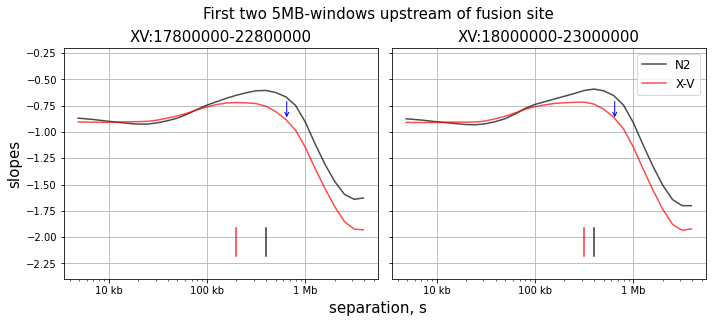

In [19]:
f, axs = plt.subplots(
    figsize=(10, 4),
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True
)

labels = ['N2','X-V']
colors = ['black','red']
sub_titles = ['XV:17800000-22800000','XV:18000000-23000000']
dat_89 = [N2_slopes_89,xv_slopes_89]
dat_90 = [N2_slopes_90,xv_slopes_90]
dat = [dat_89,dat_90]

bigFont = 15
smallFont = 10

lineStyle=['-','-']

for j in range(len(dat)):
    dat_j = dat[j]
    ax = axs[j]
    for i in range(len(dat_j)):
        ax.semilogx(dat_j[i][1]['s_bp'],dat_j[i][1]['slope'],color=colors[i],alpha=0.7,label=labels[i])
        x = dat_j[i][2]
        print(x)
        loops1 = x[np.logical_and(x>50000,x<=1000000)]
        for k in range(len(loops1)):
            ax.axvline(loops1[k],ymin=0.1,ymax=0.22,alpha=0.8,color=colors[i],linestyle=lineStyle[i])
    ax.annotate(text='',xy = (650_000,-0.88), xytext=(650_000,-0.69),
                arrowprops=dict(arrowstyle="->",color='blue'))

    ax.set_ylim(-2.4,-0.2)
    ax.set(ylabel='')
    ax.set_title(sub_titles[j],fontsize=bigFont)
    ax.grid()
    format_ticks(ax,y=False,rotate=False)
    if j == 0:
        ax.set(ylabel='slopes')
        ax.yaxis.label.set_size(bigFont)
    
f.text(0.53, -0.02, 'separation, s', ha='center',fontsize=bigFont)
f.text(0.53, 1, 'First two 5MB-windows upstream of fusion site', ha='center',fontsize=bigFont)
axs[1].legend(loc=('upper right'),prop={'size': 12})


plt.tight_layout()

In [20]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2s_slopes_window5mb_step200kb_HiC2kb_crossSection.pdf',dpi=800,bbox_inches='tight')

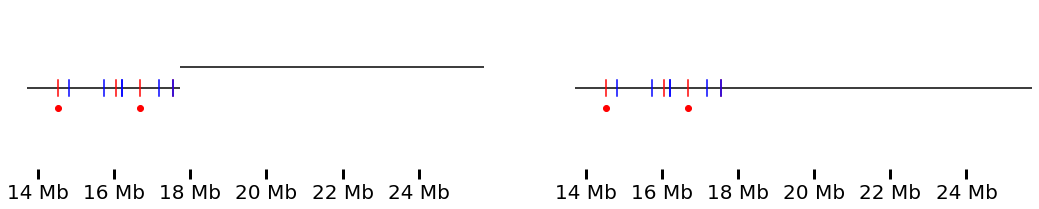

In [48]:
####### make schematics of XV ####


########################## cartoon of global annotation ############################
f, axs = plt.subplots(
    figsize=(18,3),
    ncols=2,
    nrows=1,
    sharex=False,sharey=True
)


size_XV = 38642161
XV_site = 17718513

# region 
XV_site = 17718513
up = 4_000_000
down = 8_000_000
start,end = XV_site-up, XV_site+down


# global param
boxheight = 1.5


annots = [strong,intermediate,DCCdep]
labels = ['strong rex','interm. rex','DCC-dependent\nboundary rex']
colors = ['red','blue','red']
tickProp = 0.1


# chromosome-XV (normal karyotype)
for j in range(2):
    ax = axs[j]
    if j == 0:
        d = 0.5
    else:
        d = 0
    ax.hlines(0,0,XV_site,color='black') 
    ax.hlines(d,XV_site,size_XV,color='black') 
        
    annot_leg = []
    for i in range(len(annots)):
        annot_i = bed3_mids(annots[i],'X',start,XV_site)
        for a in range(len(annot_i)):
            if i < 2:
                ax.axvline(x=annot_i[a],ymin=0.5-tickProp/2,ymax=0.5+tickProp/2,
                            c=colors[i],alpha=1,label=labels[i])
            if i == 2:
                ax.plot(annot_i[a], -0.5, 'o',color=colors[i],label=labels[i])
                
for i in range(2):
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].get_yaxis().set_ticks([])
    format_ticks(axs[i],x=True,y=False,rotate=False)
    axs[i].tick_params(axis='x', which='major', labelsize=20)
    axs[i].xaxis.set_tick_params(width=3,length=10)
    axs[i].set_ylim([-2,2])
    axs[i].set_xlim([start,end])
    
    
#axs[1].vlines(XV_site,-1.8,1.8, linestyles ="dotted",color='black')
    
    

In [49]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig2_fusion_schematics.pdf',dpi=800,bbox_inches='tight')


NameError: name 'size_X' is not defined

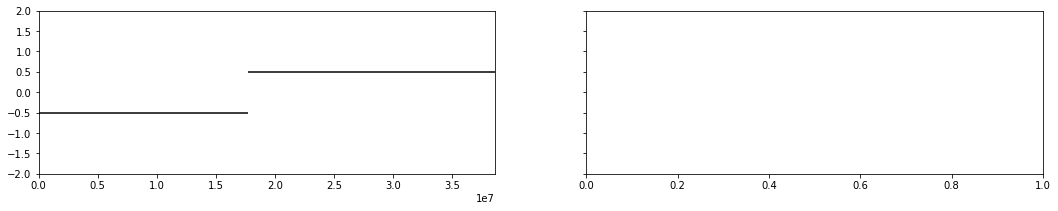

In [25]:
####### make schematics of XV ####


########################## cartoon of global annotation ############################
f, axs = plt.subplots(
    figsize=(18,3),
    ncols=2,
    nrows=1,
    sharex=False,sharey=True
)


size_XV = 38642161
XV_site = 17718513

# global param
boxheight = 1.5

# chromosome-XV (normal karyotype)
ax1 = axs[0]

ax1.hlines(-0.5,0,XV_site,color='black') 
ax1.hlines(0.5,XV_site,size_XV,color='black') 

ax1.set_ylim([-2,2])
#rect = patches.Rectangle((start_I, 0-boxheight/2), end_I-start_I, boxheight, linewidth=1.5, 
#                         edgecolor='none', facecolor='grey',alpha=0.25,label='snapshot')
#ax1.add_patch(rect)
ax1.set_xlim([0,size_XV])



# chromosome-X
ax2 = axs[1]
ax2.hlines(0,0,size_X,color='black') 
ax2.set_ylim([-2,2])
ax2.set_xlim([0,size_X])

annots = [strong,intermediate,DCCdep]
labels = ['strong rex','interm. rex','DCC-dependent\nboundary rex']
colors = ['red','blue','red']
tickProp = 0.1

annot_leg = []
for i in range(len(annots)):
    annot_i = bed3_mids(annots[i],'X',0,size_X)
    for a in range(len(annot_i)):
        if i < 2:
            ax2.axvline(x=annot_i[a],ymin=0.5-tickProp/2,ymax=0.5+tickProp/2,c=colors[i],alpha=1,label=labels[i])
        if i == 2:
            ax2.plot(annot_i[a], -0.5, 'o',color=colors[i],label=labels[i])
        
#rect = patches.Rectangle((start_X, 0-boxheight/2), end_X-start_X, boxheight, linewidth=1.5,
#                         edgecolor='none', facecolor='grey',alpha=0.25,label='snapshot')
#ax2.add_patch(rect)

for i in range(2):
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].get_yaxis().set_ticks([])
    format_ticks(axs[i],x=True,y=False,rotate=False)
    axs[i].tick_params(axis='x', which='major', labelsize=20)
    axs[i].xaxis.set_tick_params(width=3,length=10)

axs[0].set_xticks([0,5_000_000,10_000_000,15_000_000])
axs[1].set_xticks([0,5_000_000,10_000_000,15_000_000,17_700_000])



ax1.text(100_000, -1.4, 'Chromosome-I', fontsize=23,
        bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 7})
ax2.text(100_000, -1.4, 'Chromosome-X', fontsize=23,
        bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 7})

## legend ##
handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = f.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.12, 0.8),prop={'size': 17},
               handlelength=0.8)
leg._legend_box.align = "left"
leg.get_frame().set_linewidth(2)
        
plt.tight_layout()